### Version 04 
In this version, we switched `HashVectorizer()` to `CountVectorizer()`. While true positive rate for key models improved, false positive rate also went up.

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [7]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer()
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [8]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 74849)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [9]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("performance_measures is:", type(ols_performance_train.performance_measures))

{'Pos': 10000, 'Neg': 10000, 'TP': 5026, 'TN': 4983, 'FP': 5017, 'FN': 4974, 'Accuracy': 0.50045, 'Precision': 0.5004480732848751, 'Recall': 0.5026, 'desc': 'ols_train'}
performance_measures is: <class 'dict'>


### MODEL: SVM, linear

In [10]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [11]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 9691, 'TN': 9906, 'FP': 94, 'FN': 309, 'Accuracy': 0.97985, 'Precision': 0.9903934593765968, 'Recall': 0.9691, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [13]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [14]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 8293, 'TN': 7428, 'FP': 2572, 'FN': 1707, 'Accuracy': 0.78605, 'Precision': 0.7632765761619881, 'Recall': 0.8293, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

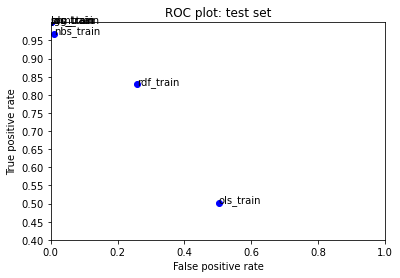

In [16]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [17]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
logistic reg                   1.0000               0.0000
perceptron                     1.0000               0.0000
ridge reg                      1.0000               0.0000
support vector                 1.0000               0.0000
naive bayes                    0.9691               0.0094
random forest                  0.8293               0.2572
ordinary least sq              0.5026               0.5017


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [19]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [20]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
117
One of the worst films I have ever had the displeasure of sitting through, Killer Tongue is a horrible melange of the worst elements of The Rocky Horror Picture Show, Brain Damage, and Pulp Fiction. Designed primarily to offend, apparently, but so inane that only the most hidebound conservatives would be taken in by it.
* * * * * * * * * 
220
I rented this one on DVD without any prior knowledge. I was suspicious seeing Michael Madsen appearing in a movie I have never heard of, but it was a freebie, so why not check it out.<br /><br />Well my guess is that Mr. Blonde would very much like to forget he's ever taken part in such a shame of a film.<br /><br />Apparently, if your script and dialogs are terrible, even good actors cannot save the day. Not to mention the amateur actors that flood this film. Too many non-native-English-speakers play parts of native-English-speakers, reading out lines from a script that should have been thrown away and not having 

3876
How did such a terrible script manage to attract this cast? Ridiculous, predictable and thoroughly unbelievable, this is well-acted and slickly directed, but the material is so bad it still qualifies as one of the all-time worst thrillers I've seen in years. Amazingly bad, and not in a fun way. Avoid at all costs, even if you're a fan of someone in the cast.
* * * * * * * * * 
3920
After coming off the first one you think the wayans brothers could come up with some new jokes. Though i guess not. If the first one wasn't bad enough this one is just so bad it hurts to watch. With all the actors they had in this film you think they could come up with something a little more clever. Though they couldn't, they had to take all the same raunchy, not funny jokes from the first one and somehow put it into this film thinking people would laugh at it again. Though the thing is i didn't laugh at it the first time. They tried to make these movies into parodies though they failed at every level.

7541
This movie could have been 15 minutes long if it weren't for all the bickering between son and father. Very predictable. Both Male \stars\" need a good slap in the face! Would you like some cheese with that \"whine?\" Two chuckles...and a headache. I can understand why the mother left her hubby after 47 years...I don't know how she lasted that long! The first 5 minutes made me want to turn the movie off wishing I had never paid the $3.99 to watch it! The movie didn't flow well and was painfully long. I kept watching my watch hoping time would fly faster...It didn't. The script had so much repetition that it had to be easy for the writer to fill space. On a positive note...the scenery was pretty, fall being my favorite season. The car, the 40 Ford was also quite nice. This movie gets an D- rating approaching an F"
* * * * * * * * * 
7764
I thought that the nadir of horror film making had been reached with \Book of Shadows\", I was wrong. This film makes that look like \"The Magnfic

11712
So this guy named George is sitting home alone on his birthday when two women show up. George's wife is at a hospital taking care of their son so when the wife is away George gets in the bubble bath and makes love to both of the girls. It isn't that great of a scene because it really doesn't show anything. After that the birthday boy wakes up the next morning and the girls are still at his house. They make him a nice breakfast but George isn't hungry. George isn't very happy and he tries to ditch them but when he gets home the girls are still at his house. The girls have had enough with old George and no longer want to cook for them. They both turn out to be major psychopaths and use George in their little crazy game. I liked that the girls just did what they wanted and messed up George's house. George wasn't really that great to his two guests. When George said he was a married man, he really didn't seem to mean it. George looked like Tom Tucker on Family Guy. I was for the two 

15395
THE TEMP (1993) didn't do much theatrical business, but here's the direct-to-video rip-off you didn't want, anyway! Ellen Bradford (Mel Harris) is the new woman at Millennium Investments, a high scale brokerage firm, who starts getting helpful hints from wide-eyed secretary Deidre (Sheila Kelley). Deidre turns out to be an ambitious daddy's girl who will stop at nothing to move up the corporate ladder, including screwing a top broker she can't stand and murdering anyone who gets on her bad side. She digs up skeletons in Ellen's closet, tries to cause problems with her husband (Barry Bostwick), kills while making it look like she is responsible, kidnaps her daughter and tries to get her to embezzle money from the company.<br /><br />Harris and Kelley deliver competent performances, the supporting cast is alright and it's reasonably well put-together, but that doesn't fully compensate for a script that travels down a well-worn path and offers few surprises.
* * * * * * * * * 
15820

19111
After watching Awake,I led to a conclusion:director and screenwriter Joby Harold made Awake with the intention of laughing at the spectator,for the simple fact the movie is full of ridiculous elements.Awake has a lot of plot holes and it is full of absurd and ridiculous elements(for example,the hospital uniform the spirit of the main character uses...did the ghost of a doctor leave it in the floor ?).The concept behind this movie is slightly ingenious but all the plot holes and the absurd things make of this a stupid and crappy film.With the exception of the great Lena Olin,all the actors bring bad performances.Hayden Christensen has zero expressions and the same applies for Jessica Alba.The extraordinary actor Terrence Howard is enormously wasted on his role.Awake makes a laugh of the spectator.It's so ridiculous and full of absurd things that it's impossible to take it seriously.My recommendation is:skip this crappy movie.
* * * * * * * * * 
19145
This week, I just thought it w

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [21]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1223, 'TN': 1261, 'FP': 1239, 'FN': 1277, 'Accuracy': 0.4968, 'Precision': 0.4967506092607636, 'Recall': 0.4892, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [22]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2089, 'TN': 2099, 'FP': 401, 'FN': 411, 'Accuracy': 0.8376, 'Precision': 0.8389558232931726, 'Recall': 0.8356, 'desc': 'svm_test'}


### MODEL: logistic regression

In [23]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2073, 'TN': 2065, 'FP': 435, 'FN': 427, 'Accuracy': 0.8276, 'Precision': 0.8265550239234449, 'Recall': 0.8292, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [24]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1860, 'TN': 1907, 'FP': 593, 'FN': 640, 'Accuracy': 0.7534, 'Precision': 0.7582551977170812, 'Recall': 0.744, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [25]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2103, 'TN': 2091, 'FP': 409, 'FN': 397, 'Accuracy': 0.8388, 'Precision': 0.8371815286624203, 'Recall': 0.8412, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [26]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2129, 'TN': 2067, 'FP': 433, 'FN': 371, 'Accuracy': 0.8392, 'Precision': 0.8309914129586261, 'Recall': 0.8516, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [27]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)
print(rdf_performance_test)

{'Pos': 2500, 'Neg': 2500, 'TP': 2079, 'TN': 1840, 'FP': 660, 'FN': 421, 'Accuracy': 0.7838, 'Precision': 0.7590361445783133, 'Recall': 0.8316, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

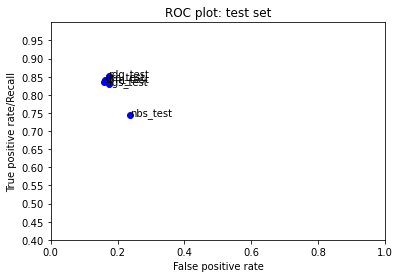

In [28]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [29]:
#https://pavopax.github.io/2017/11/precision-recall/
#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba#:~:text=Recall%20and%20True%20Positive%20Rate,denominator%20contains%20the%20true%20negatives.
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
ridge reg                      0.8516               0.1732
perceptron                     0.8412               0.1636
support vector                 0.8356               0.1604
random forest                  0.8316               0.2640
logistic reg                   0.8292               0.1740
naive bayes                    0.7440               0.2372
ordinary least sq              0.4892               0.4956


---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation